In [1]:
import sys
sys.path.insert(0, '/home/ldoyle/packages')
import h5py
import matplotlib.dates as mdates
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd

from lr_ed import localreg

from scipy.signal import butter, filtfilt

In [2]:
path = "/data/data2/south-data-ejm/hdd/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T16_09_15-0700/"
file = "South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231114Z.h5"

f = h5py.File(path+file, 'r')
data = f['Acquisition']['Raw[0]']['RawData'][:, :].astype('int64')
timestamp = f['Acquisition']['Raw[0]']['RawDataTime'][:] / 1000000
f.close()

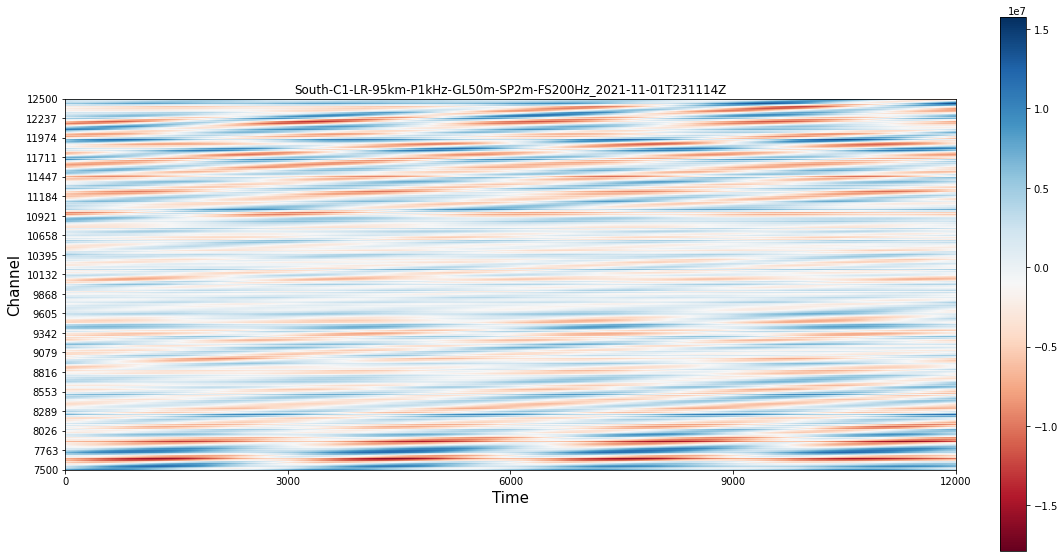

In [6]:
date_format = mdates.DateFormatter('%d-%b\n%H:%M:%S.%f')

downsample_space=10 # At the scale of plotting, the downsampling is imperceptible
downsample_time=10 # At the scale of plotting, the downsampling is imperceptible

# x_lims = list(map(datetime.utcfromtimestamp, [timestamp[0], timestamp[-1]]))
# x_lims = mdates.date2num(x_lims)
x_lims = [0,12000]
y_lims = [7500,12500]
fig, ax = plt.subplots(figsize = (16, 8))
fig.patch.set_facecolor('white') # Good for dark themed notebooks
plt.tight_layout()
im = ax.imshow((data[y_lims[0]:y_lims[1]:downsample_space,::downsample_time]),
               extent = [x_lims[0], x_lims[1],  y_lims[0], y_lims[1]],
               cmap = 'RdBu')
# ax.xaxis_date()
plt.xlabel("Time", fontsize = 15)
plt.ylabel("Channel", fontsize = 15)
# ax.xaxis.set_major_formatter(date_format)
# plt.xticks(rotation=15)

plt.xticks(np.linspace(x_lims[0], x_lims[1], 5))
plt.yticks(np.linspace(y_lims[0], y_lims[1], 20))
plt.title(file.split('.')[0])
plt.colorbar(im, ax = ax, pad = 0.04)
plt.show()

### Kernel Smooth

In [3]:
def kernel(t):
    res = (1/np.sqrt(2*np.pi))*np.exp(-0.5*t**2)
    return res

In [7]:
sliced_data = np.array( data[7500:12500,:])

In [8]:
radius = 10
size_val = sliced_data.shape[0]
x0 = np.arange(size_val).reshape(-1,1)

weight_matr = np.zeros((size_val,size_val))
incl_list = []
for i, xi in enumerate(x0):
    weight_matr[i,:] = kernel(np.linalg.norm(x0-xi[None,:], axis=1)/radius)

    incl_list.append( np.where(np.abs(weight_matr[i,:])>1e-10)[0])

In [9]:
def gauss_lr(q):
    return localreg(np.arange(size_val),sliced_data[:,q], degree=0, weight_matr=weight_matr,ind_list=incl_list)

In [10]:
smoothed_dat = np.array(np.zeros((5000,12000)))
for i in tqdm(range(12000)):
    smoothed_dat[:,i] = gauss_lr(i)

100%|██████████| 12000/12000 [29:29<00:00,  6.78it/s]


In [11]:
np.save('gaussian_smoothed_11_2_2022_channels_7500_12500'+file[:-3]+'.npy', smoothed_dat)

### Bandpass Filter

In [29]:
low_cut=10**(-6)
hi_cut=50
b,a = butter(4,(low_cut,hi_cut),'bp',fs=200)
data_filt = filtfilt(b,a,data[7500:12500,:],axis=0)

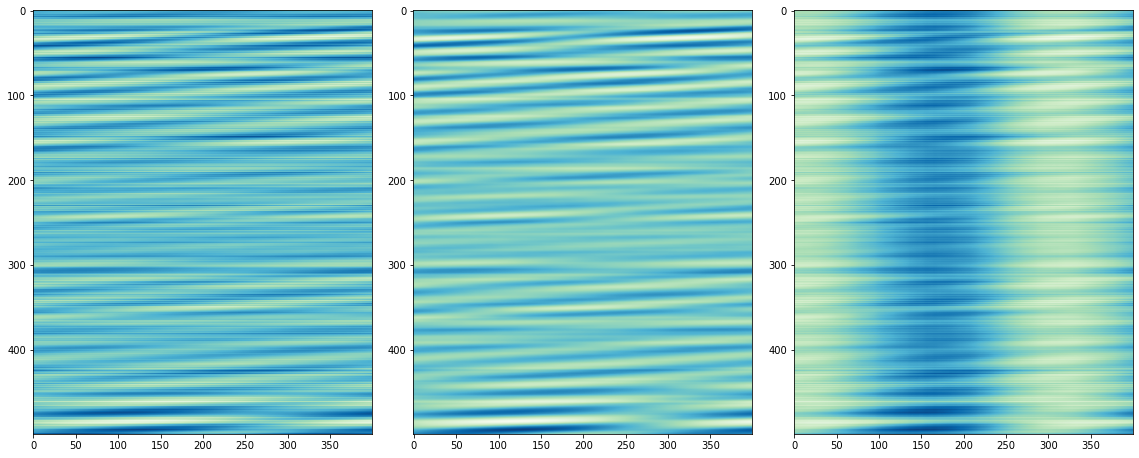

In [30]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize = (16,10))
fig.patch.set_facecolor('white') # Good for dark themed notebooks
plt.tight_layout()

im = ax1.imshow((sliced_data[::10,:4000:10]),
                cmap = 'GnBu')

im2 = ax2.imshow((smoothed_dat[::10,:4000:10]),
                cmap = 'GnBu')

im2 = ax3.imshow((data_filt[::10,:4000:10]),
                cmap = 'GnBu')
# plt.xlabel("Time", fontsize = 15)
# plt.ylabel("Channel", fontsize = 15)

# plt.colorbar(im, ax = ax2, pad = 0.04)
plt.show()